<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/03_FraudDetection_noOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [849]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Runtime switched to GPU
GPU device not found
Please install GPU version of TF


In [850]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Cleaning

In [851]:
# Remove Na and Empty Columns

df.drop(['Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 'Customer Password'], axis = 1, inplace = True) 
df.dropna(inplace = True) #remove 1 missing value

## Category Column


1. **COMPLETE:** The order or transaction has been successfully fulfilled and completed.
2. **PENDING**: The order or transaction is still in progress and has not yet been completed.
3. **CLOSED**: The order or transaction has been closed or terminated for some reason, such as a return or cancellation.
4. **PENDING_PAYMENT**: The order or transaction is awaiting payment before it can be processed.
5. **CANCELED**: The order or transaction has been canceled by the customer or the seller for some reason.
6. **PROCESSING**: The order or transaction is being processed by the seller or merchant.
7. **SUSPECTED_FRAUD**: The order or transaction is under review due to suspected fraudulent activity.
8. **ON_HOLD**: The order or transaction has been placed on hold for some reason, such as a delay in shipping or a credit hold.
9. **PAYMENT_REVIEW**: The payment for the order or transaction is under review by the payment processor or financial institution.

In [852]:
# Regular -> Complete, Pending, Pending_Payment, Processing
# Suspected -> Closed, Canceled, On_Hold, Payment_Review
# Fraud -> Suspected_Fraud

# define dictionaries to map status values to categories
regular_dict = {'COMPLETE': 'Regular', 'PENDING': 'Regular', 'PENDING_PAYMENT': 'Regular', 'PROCESSING': 'Regular'}
suspected_dict = {'CLOSED': 'Suspected', 'CANCELED': 'Suspected', 'ON_HOLD': 'Suspected', 'PAYMENT_REVIEW': 'Suspected'}
fraud_dict = {'SUSPECTED_FRAUD': 'Fraud'}

# create a function to map status values to categories
def map_category(status):
    if status in regular_dict:
        return regular_dict[status]
    elif status in suspected_dict:
        return suspected_dict[status]
    elif status in fraud_dict:
        return fraud_dict[status]
    else:
        return 'Unknown'

# apply the function to the 'status' column to create a new 'category' column
df['Category'] = df['Order Status'].apply(map_category)

print('Regular: ', len([x for x in df['Category'] if x == 'Regular']), '\n')
print('Suspected: ', len([x for x in df['Category'] if x == 'Suspected']), '\n')
print('Fraud: ', len([x for x in df['Category'] if x == 'Fraud']))

Regular:  141442 

Suspected:  35004 

Fraud:  4062


In [853]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

temp = df["Category"].value_counts()
df1 = pd.DataFrame({'Category': temp.index,'values': temp.values})

# Define a list of colors for the bars
colors = ['red', 'blue', 'green']

traces = []
for i, category in enumerate(df1['Category']):
    if category == 1:
        name = "Regular"
    elif category == 0:
        name = "Suspected"
    else:
        name = "Fraud"
    trace = go.Bar(
        x=[name], y=[df1.loc[i, 'values']],
        name=name,
        marker=dict(color=colors[i]),
        text=[df1.loc[i, 'values']],
        legendgroup="group"
    )
    traces.append(trace)

layout = dict(title='Credit Card Fraud Class - data unbalance',
              xaxis=dict(title='Class', showticklabels=True), 
              yaxis=dict(title='Number of transactions'),
              hovermode='closest', width=600,
              showlegend=True
             )
fig = go.Figure(data=traces, layout=layout)
iplot(fig, filename='class')

## Encoding

In [854]:
from sklearn.model_selection import train_test_split

df.drop(['Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer State',	'Customer Street', 
       'Order City', 'Order Country', 'Order Customer Id', 'Order Region',	
       'Order State', 'Product Image',	'Product Name',
       'shipping date (DateOrders)', 'order date (DateOrders)', 'Category Id', 'Customer Zipcode', 
       'Department Id', 'Latitude',	'Longitude', 'Order Id',	'Order Item Cardprod Id',
       'Order Item Id', 'Product Card Id', 'Product Category Id'], axis = 1, inplace = True)

df.to_csv('/content/drive/MyDrive/University/Deloitte/df_number.csv', index = False)

In [855]:
from sklearn.model_selection import train_test_split  

df.drop(['Order Status'], axis=1, inplace=True)

X = df.drop(['Category'], axis=1)
y = df['Category']

In [856]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Type
onehot = pd.get_dummies(X['Type'])
X = pd.concat([X, onehot], axis=1)
X.drop(['Type'], axis=1, inplace=True)

# Department Name
onehot = pd.get_dummies(X['Department Name'])
X = pd.concat([X, onehot], axis=1)
X.drop(['Department Name'], axis=1, inplace=True)

# Market
onehot = pd.get_dummies(X['Market'])
X = pd.concat([X, onehot], axis=1)
X.drop(['Market'], axis=1, inplace=True)

# Customer Segment
onehot = pd.get_dummies(X['Customer Segment'])
X = pd.concat([X, onehot], axis=1)
X.drop(['Customer Segment'], axis=1, inplace=True)

In [857]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

In [858]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

# Delivery Status
# Define the custom order
custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
le.fit(custom_order)
X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [859]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

# Define the column transformer to apply scaling only to non-one-hot-encoded columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), list(range(0, 16)))
    ],
    remainder="passthrough"
)

column_names = list(X_train.columns)

# Create a pipeline with the preprocessor and any other desired transformers
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    # add other transformers or classifiers as desired
])

# Fit and transform the input data using the pipeline
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

X_train = pd.DataFrame(X_train, columns=column_names)
X_test = pd.DataFrame(X_test, columns=column_names)

In [860]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

print(X_train.shape, y_train.shape)
print(type(X), type(y))

(144406, 39) (144406,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


# PCA

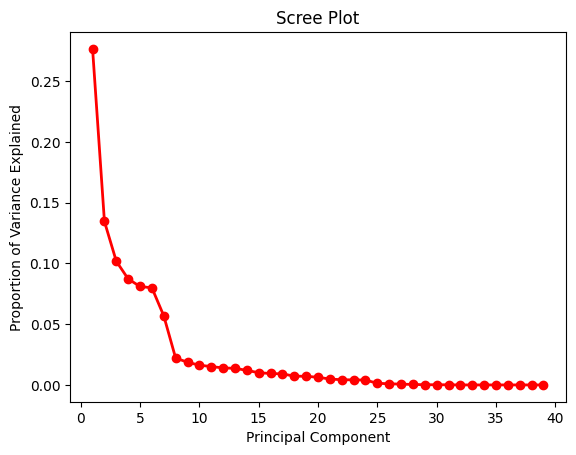


 Number of components to keep: 17


In [427]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

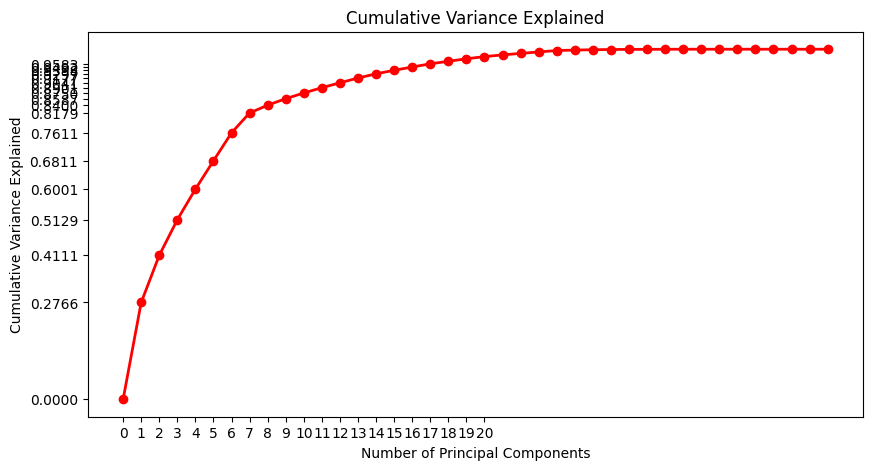

In [428]:
# Plot the cumulative variance explained

fig = plt.figure(figsize=(10, 5))

cum = np.insert(cumulative_variance_ratio, 0, 0)
ylab = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(cum, 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.yticks(ylab)
plt.xticks(np.arange(0, 21))
plt.show()

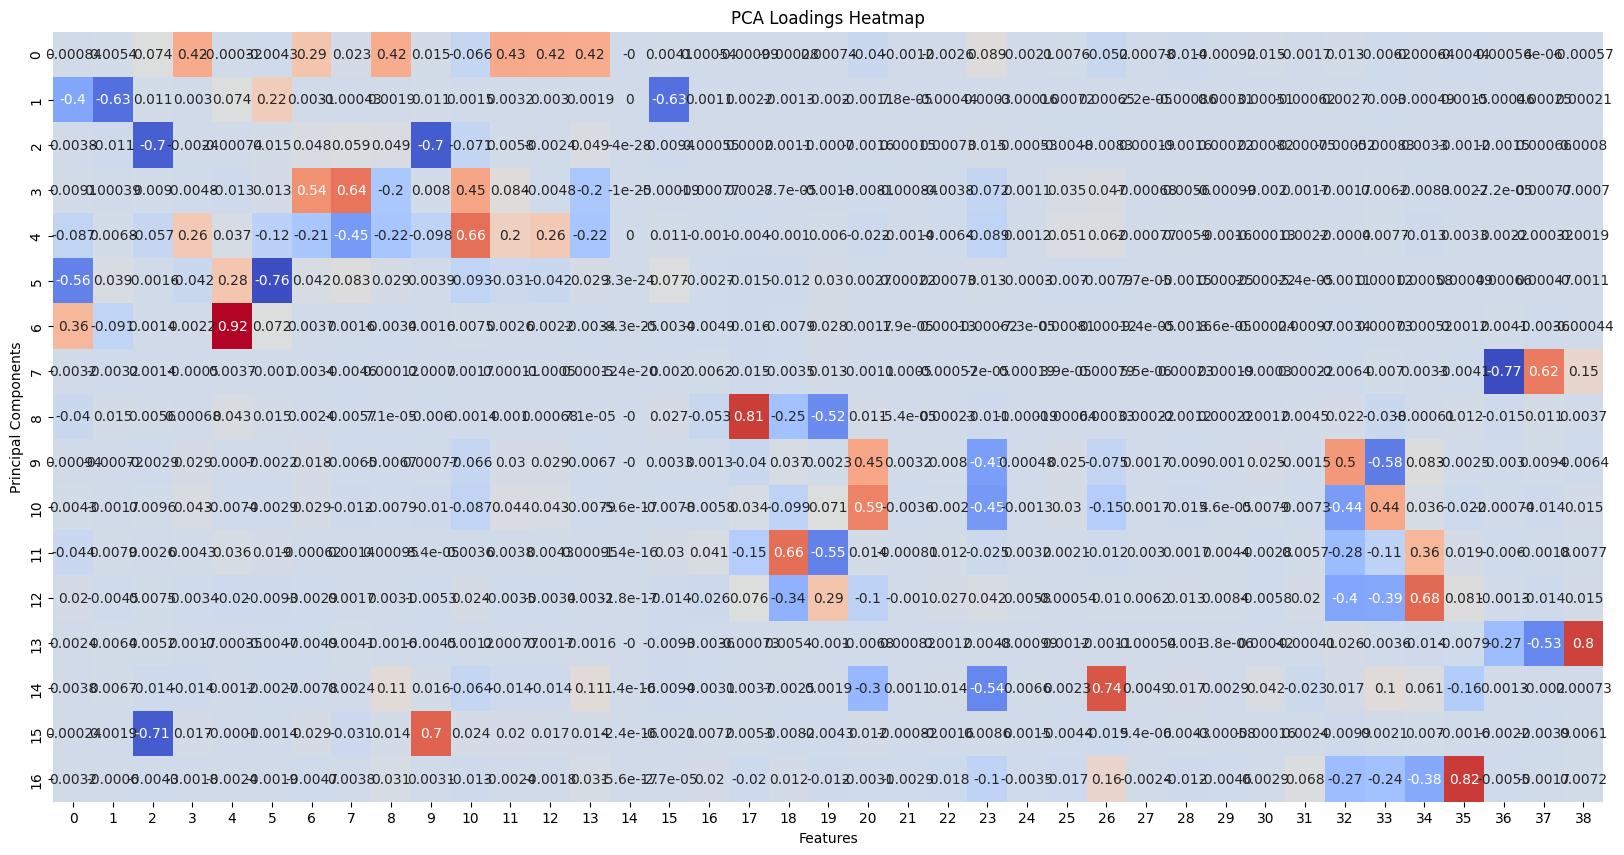

In [429]:
import seaborn as sns

# Heatmap loadings
fig = plt.figure(figsize=(20, 10))
sns.heatmap(pca.components_, cmap='coolwarm', annot=True, cbar=False)
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.title('PCA Loadings Heatmap')
plt.show()

In [ ]:
# Get the principal components as vectors in the original feature space
pc_vectors = pca.components_

# Get the names of the original columns
column_names = X.columns

# Print the names of the columns chosen as principal components
num_pcs = pc_vectors.shape[0]
for i in range(num_pcs):
    pc_name = f'PC{i+1}'
    pc_loadings = pc_vectors[i]
    relevant_columns = column_names[np.abs(pc_loadings) >= 0.40]
    print(f'{pc_name}:\n {relevant_columns.tolist()}, \n {pc_loadings[np.abs(pc_loadings) >= 0.40]} \n ')

# PCA MCA

In [861]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train.iloc[:, :16])

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
pca_train = pca.fit_transform(X_train.iloc[:, :16])
pca_test = pca.transform(X_test.iloc[:, :16])


 Number of components to keep: 7


In [862]:
onehot_data_train = X_train.iloc[:, 16:]
onehot_data_test = X_test.iloc[:, 16:]

In [863]:
X_train = pd.concat([pd.DataFrame(pca_train), pd.DataFrame(onehot_data_train)], axis=1)
X_test = pd.concat([pd.DataFrame(pca_test), pd.DataFrame(onehot_data_test)], axis=1)

In [864]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [865]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4)

model.fit(X_train, y_train)

with open('rf.pkl', 'wb') as file:
    pickle.dump(model, file)

In [866]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('rf.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

RandomForestClassifier(class_weight='balanced', max_depth=4)
Confusion Matrix
 [[  807     5     0]
 [ 2264 26025     0]
 [  754  2334  3913]] 

Recalls [0.9938 0.92   0.5589]
Precisions [0.211  0.9175 1.    ]


In [803]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=100, max_depth=4)

model.fit(X_train, y_train)

with open('gb.pkl', 'wb') as file:
    pickle.dump(model, file)

In [867]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('gb.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

GradientBoostingClassifier(max_depth=4)
Confusion Matrix
 [[  399   157   256]
 [  199 26480  1610]
 [  314  2293  4394]] 

Recalls [0.4914 0.9361 0.6276]
Precisions [0.4375 0.9153 0.7019]


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

model_bagging = BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4), n_estimators=100)

model.fit(X_train, y_train)

with open('bagging.pkl', 'wb') as file:
    pickle.dump(model_bagging, file)

In [826]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

model_voting = VotingClassifier(estimators=[], voting='hard')

model.fit(X_train, y_train)

with open('voting.pkl', 'wb') as file:
    pickle.dump(model_voting, file)

In [687]:
import xgboost as xgb

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=200, learning_rate=0.1)

model.fit(X_train, y_train)

with open('xgb.pkl', 'wb') as file:
    pickle.dump(model, file)

In [868]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('xgb.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)
Confusion Matrix
 [[  541    18   253]
 [    0 28245    44]
 [  380  2339  4282]] 

Recalls [0.6663 0.9984 0.6116]
Precisions [0.5874 0.923  0.9351]


In [873]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4), n_estimators=100)

model.fit(X_train, y_train)

with open('ada.pkl', 'wb') as file:
    pickle.dump(model, file)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



In [874]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('ada.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                         max_depth=4),
                   n_estimators=100)
Confusion Matrix
 [[  795     0    17]
 [    0 27455   834]
 [  741  2228  4032]] 

Recalls [0.9791 0.9705 0.5759]
Precisions [0.5176 0.9249 0.8257]


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3)

model.fit(X_train, y_train)

with open('cat.pkl', 'wb') as file:
    pickle.dump(model, file)

In [829]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('cat.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

Confusion Matrix
 [[  585   219     8]
 [    0 28287     2]
 [  534  2519  3948]] 

Recalls [0.7204 0.9999 0.5639]
Precisions [0.5228 0.9117 0.9975]


In [691]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=3, covariance_type='full', max_iter=100, random_state=0)

model.fit(X_train)

with open('gmm.pkl', 'wb') as file:
    pickle.dump(model, file)

In [832]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('gmm.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

GaussianMixture(n_components=3, random_state=0)
Confusion Matrix
 [[  618   149    45]
 [19653  7169  1467]
 [ 5013  1644   344]] 

Recalls [0.7611 0.2534 0.0491]
Precisions [0.0244 0.7999 0.1853]


In [693]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=1000)

model.fit(X_train, y_train)

with open('lr.pkl', 'wb') as file:
    pickle.dump(model, file)

In [834]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('lr.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

LogisticRegression(class_weight='balanced', max_iter=1000)
Confusion Matrix
 [[  706   106     0]
 [ 2030 24432  1827]
 [  626  2118  4257]] 

Recalls [0.8695 0.8637 0.6081]
Precisions [0.21   0.9166 0.6997]


In [694]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight='balanced', max_depth = 4)

model.fit(X_train, y_train)

with open('dt.pkl', 'wb') as file:
    pickle.dump(model, file)

In [835]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('dt.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

DecisionTreeClassifier(class_weight='balanced', max_depth=4)
Confusion Matrix
 [[  812     0     0]
 [  264 28025     0]
 [  740  2320  3941]] 

Recalls [1.     0.9907 0.5629]
Precisions [0.4471 0.9235 1.    ]


# Results

In [664]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import pickle

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

with open('gb.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

y_pred = model.predict(X_test)

print('Confusion Matrix\n', confusion_matrix(y_test, model.predict(X_test)), '\n')
print('Recalls', recall_score(y_test, y_pred, average=None))
print('Precisions', precision_score(y_test, y_pred, average=None))

GradientBoostingClassifier(loss='deviance', max_depth=4)
Confusion Matrix
 [[  475   131   206]
 [   25 28159   105]
 [  423  2452  4126]] 

Recalls [0.585  0.9954 0.5893]
Precisions [0.5146 0.916  0.9299]
Accuracy 0.9074289513046369


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, recall_score
import os
import pickle
import pandas as pd
import numpy as np

# Standardize the data and split it into training and test sets
s = StandardScaler()
le = LabelEncoder()

recall_scores = []
precision_scores = []
fraud_recall = []
suspected_recall = []
regular_recall = [] 
low = []
avg_conf_matrix = np.zeros((3, 3))
print(model)

for i in range(1, 11):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

  # Shipping Mode
  custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
  le.fit(custom_order)
  X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
  X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

  # Delivery Status
  # Define the custom order
  custom_order = ['Shipping on time', 'Advance shipping', 'Late delivery', 'Shipping canceled']
  le.fit(custom_order)
  X_train['Delivery Status'] = le.fit_transform(X_train['Delivery Status'])
  X_test['Delivery Status'] = le.transform(X_test['Delivery Status'])

  # Category
  y_train = le.fit_transform(y_train)
  y_test = le.transform(y_test)

  preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), list(range(0, 16)))
    ],
    remainder="passthrough")

  pipeline = Pipeline([
    ('preprocessor', preprocessor)])

  X_train = pipeline.fit_transform(X_train)
  X_test = pipeline.transform(X_test)


  # PCA
  pca = PCA()

  # Fit the PCA object to the data
  X_train = pd.DataFrame(X_train)
  X_test = pd.DataFrame(X_test)
  pca.fit(X_train.iloc[:, :16])

  # Determine the number of components to keep
  variance_threshold = 0.95
  cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
  num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

  # Transform the data using the chosen number of components
  pca = PCA(n_components=num_components_to_keep)
  pca_train = pca.fit_transform(X_train.iloc[:, :16])
  pca_test = pca.transform(X_test.iloc[:, :16])

  onehot_data_train = X_train.iloc[:, 16:]
  onehot_data_test = X_test.iloc[:, 16:]

  X_train = pd.concat([pd.DataFrame(pca_train), pd.DataFrame(onehot_data_train)], axis=1)
  X_test = pd.concat([pd.DataFrame(pca_test), pd.DataFrame(onehot_data_test)], axis=1)

  y_pred = model.predict(X_test)
  conf_matrix = confusion_matrix(y_test, y_pred)

  recall_scores.append(recall_score(y_test, y_pred, average=None))
  fraud_recall.append(recall_score(y_test, y_pred, average=None)[0])
  regular_recall.append(recall_score(y_test, y_pred, average=None)[1])
  suspected_recall.append(recall_score(y_test, y_pred, average=None)[2])
  precision_scores.append(precision_score(y_test, y_pred, average=None))

  conf_matrix = confusion_matrix(y_test, y_pred)
  avg_conf_matrix += conf_matrix

  if i % 10 == 0:
      print(f'Iteration: {i}')
      print(f'Fraud Recall {round(np.average(fraud_recall), 4)}, {round(np.std(fraud_recall), 4)}')
      print(f'Suspected Recall {round(np.average(suspected_recall), 4)}, {round(np.std(suspected_recall), 4)}')
      print(f'Regular Recall {round(np.average(regular_recall), 4)}, {round(np.std(regular_recall), 4)}')
      print(f'Total Recall {round(np.average(recall_scores), 4)}, {round(np.std(recall_scores), 4)} \n')

  if recall_score(y_test, y_pred, average=None)[0] < 0.7:
    low.append(round(recall_score(y_test, y_pred, average=None)[0], 4))
  
print(f'\n Fraud Recall: {round(np.average(fraud_recall), 4)}, std: {round(np.std(fraud_recall), 4)}, Under 0.7: {len(low)}, {low}\n Suspected Recall: {round(np.average(suspected_recall), 4)}, std: {round(np.std(suspected_recall), 4)}\n Regular Recall: {round(np.average(regular_recall), 4)}, std: {round(np.std(regular_recall), 4)}\n Total: {round(np.average(recall_scores), 4)}, std: {round(np.std(recall_scores), 4)}')

np.set_printoptions(precision=4)
avg_conf_matrix /= 20
print("\n Average Confusion Matrix:")
print(avg_conf_matrix)

print('Precisions', precision_score(y_test, y_pred, average=None))

print('\n', model)

# Synthetic Data

In [ ]:
y_test.replace({0: 'Fraud', 1: 'Regular', 2: 'Suspected'}, inplace=True)

In [ ]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1)
test

In [ ]:
!pip install git+https://github.com/sdv-dev/CTGAN.git

In [ ]:
test.select_dtypes(exclude="number").columns.tolist()

In [ ]:
from ctgan import CTGAN
import pandas as pd

categoricals = test.select_dtypes(exclude="number").columns.tolist()


ctgan = CTGAN(epochs=10)
ctgan.fit(test[:-1], categoricals)

synthetic_data = ctgan.sample(len(test))

In [ ]:
import pandas as pd
from ctgan import CTGAN

categoricals = df.select_dtypes(exclude="number").columns.tolist()

# Fit CTGAN
ctgan = CTGAN(epochs=10, batch_size=32)
ctgan.fit(df, categoricals)

# Generate the data
synthetic = ctgan.sample(20000)
synthetic.head()

In [ ]:
from sklearn.model_selection import train_test_split  

X = synthetic.drop(['Category'], axis=1) #Not scaled
y = synthetic['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

from sklearn.preprocessing import StandardScaler

s = StandardScaler()

X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit(X_train)

# Create a scree plot
num_components = len(pca.explained_variance_ratio_)
plt.plot(np.arange(1, num_components+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

# Determine the number of components to keep
variance_threshold = 0.95
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_to_keep = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

print(f'\n Number of components to keep: {num_components_to_keep}')

# Transform the data using the chosen number of components
pca = PCA(n_components=num_components_to_keep)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# Plot the cumulative variance explained

fig = plt.figure(figsize=(10, 5))

cum = np.insert(cumulative_variance_ratio, 0, 0)
ylab = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

plt.plot(cum, 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.yticks(ylab)
plt.xticks(np.arange(0, 21))
plt.show()